# Image Classification

### 3.1 Coding Questions

In [1]:
import cv2
import copy 
import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

#### Training

10


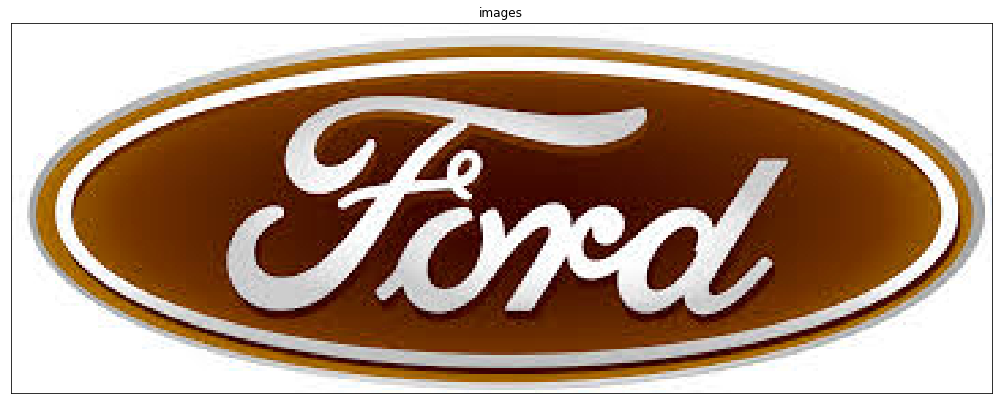

10


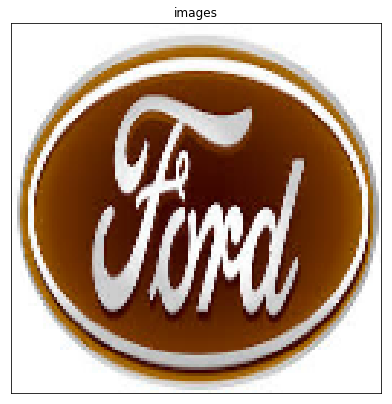

In [2]:
"""Resize the training images to 128 * 128"""

training_imgs = []
for name in glob.glob('dataset/*train*'):
    training_imgs.append(cv2.imread(name))
    
print(len(training_imgs))
# display images
plt.figure(figsize=(20,15))
plt.subplot(212), plt.imshow(training_imgs[1])
plt.title("images"), plt.xticks([]), plt.yticks([])
plt.show()
 
for img in range(len(training_imgs)): 
    # explicitly specify dsize=dst.size(); fx and fy will be computed from that.
    training_imgs[img] = cv2.resize(training_imgs[img],(128, 128));
    
print(len(training_imgs))
# display images
plt.figure(figsize=(20,15))
plt.subplot(212), plt.imshow(training_imgs[1])
plt.title("images"), plt.xticks([]), plt.yticks([])
plt.show()

In [3]:
"""Compute HoG features of size (32,32,8). Apply blocknorm in 4 x 4 cell neighborhood"""

def compute_HoG_feat(img, cell_size=(4, 4), block_size=(4, 4), nbins=8): 
    """
    Creates HoG Object and Computes HoG Features
    
    :param img: the image for which HoG is computed
    :param cell_size: h x w in pixels
    :param block_size: h x w in cells
    :param nbins: number of orientation bins
    
    :return: gradients
    """

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # create HoG Object
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                      img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

    n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

    # Compute HoG features
    hog_feats = hog.compute(img)\
                   .reshape(n_cells[1] - block_size[1] + 1,
                            n_cells[0] - block_size[0] + 1,
                            block_size[0], block_size[1], nbins) \
                   .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

    # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], nbins), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    for off_y in range(block_size[0]):
        for off_x in range(block_size[1]):
            gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                      off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                       off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count 

    # Preview
    plt.figure(figsize = (10,10))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image"), plt.xticks([]), plt.yticks([])

    bin = 0  # angle is 360 / nbins * direction
    plt.subplot(122)
    plt.pcolor(gradients[:, :, bin])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("HOG bin = 0"), plt.xticks([]), plt.yticks([])
    plt.colorbar()
    plt.show()
    
    return gradients

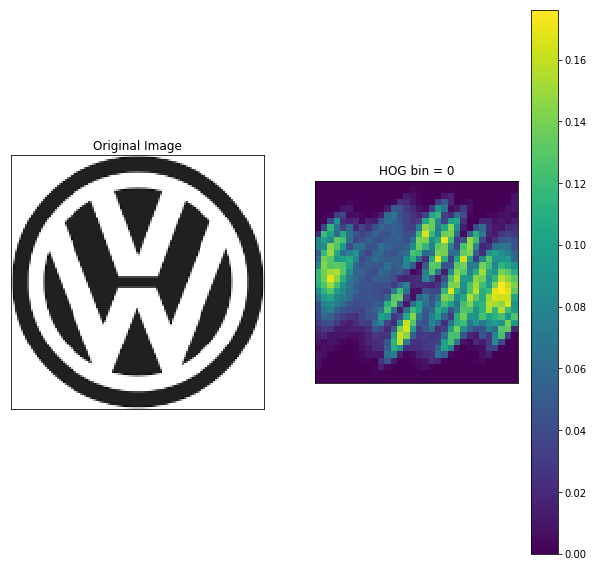

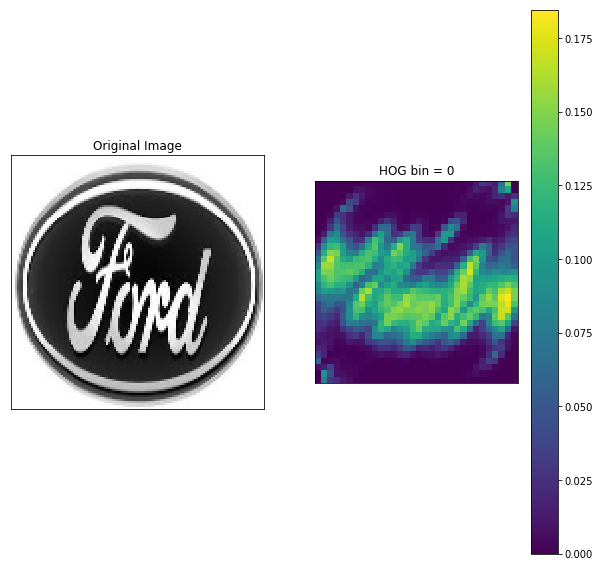

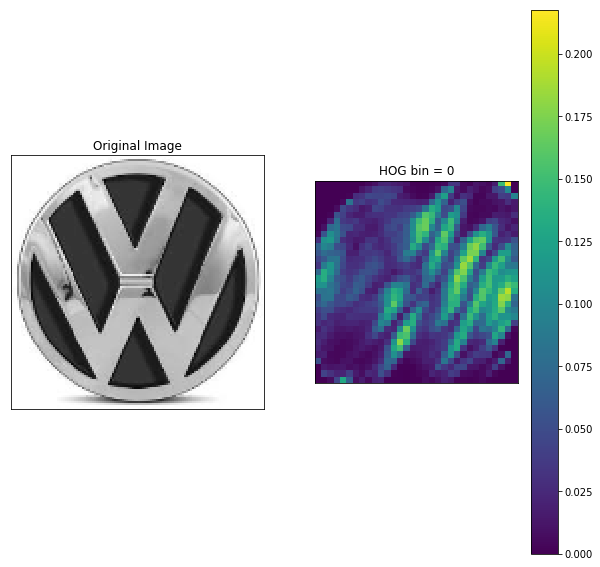

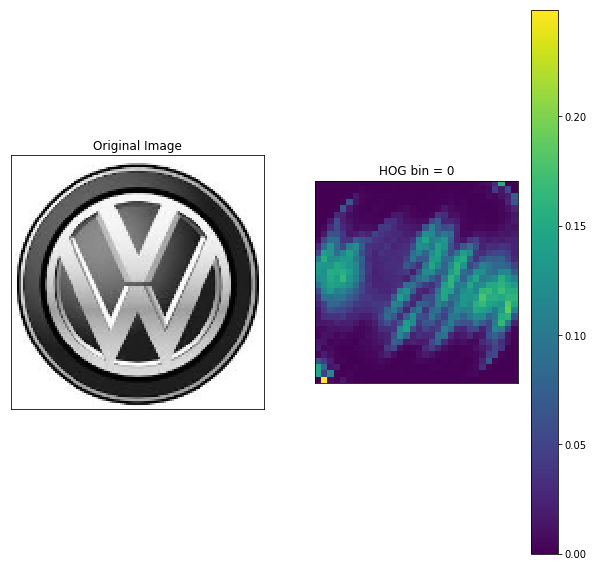

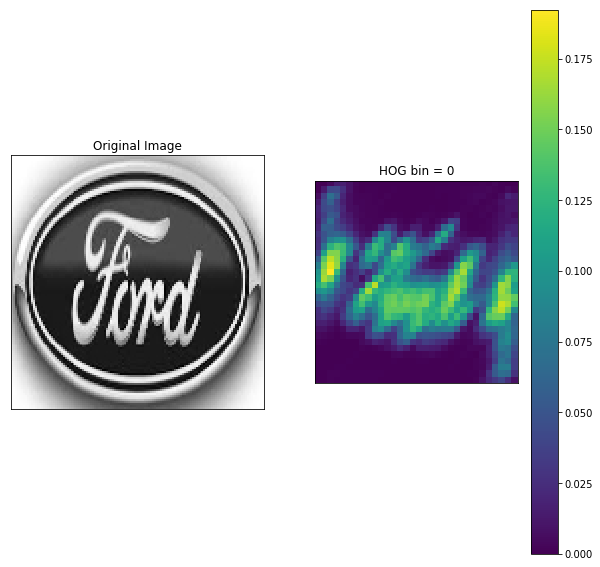

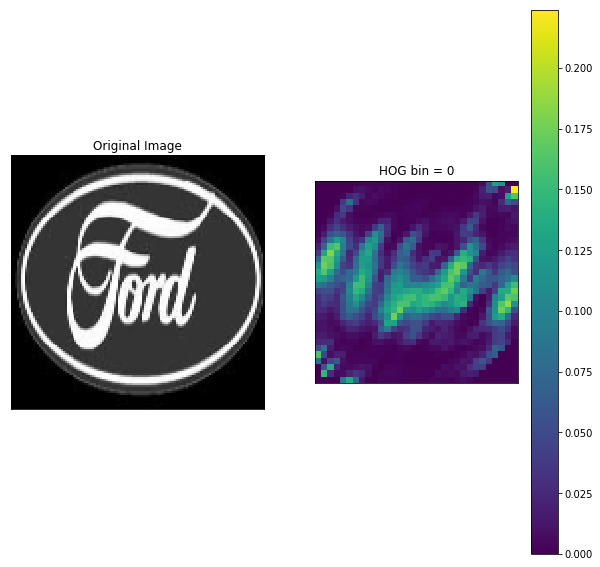

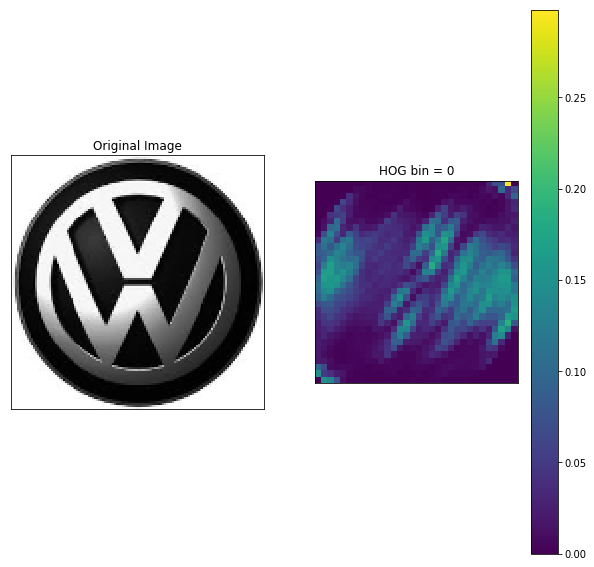

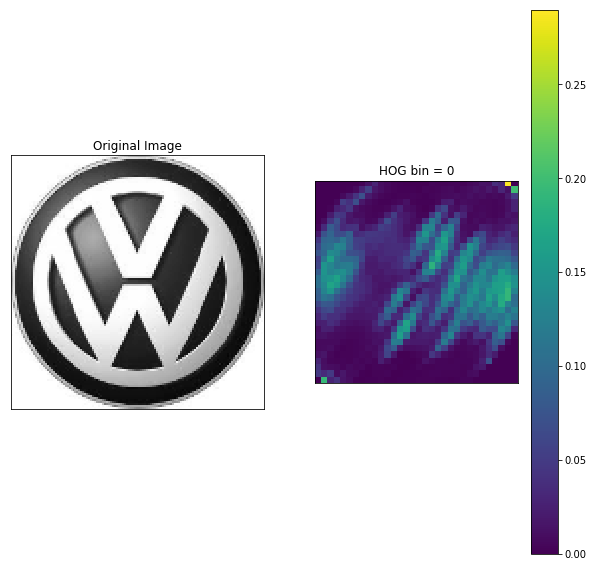

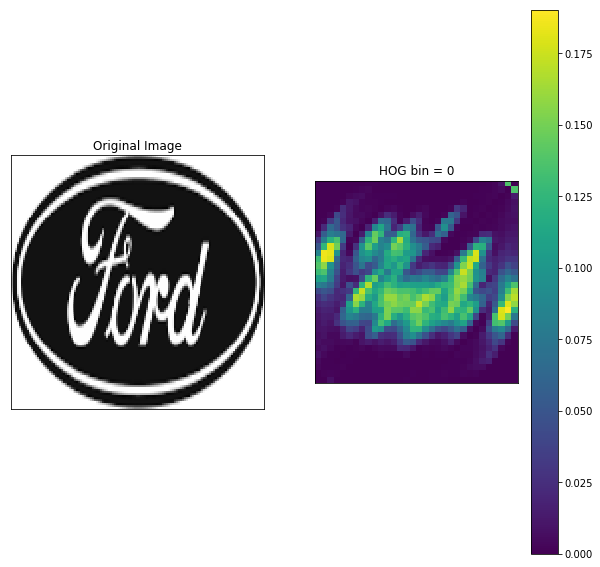

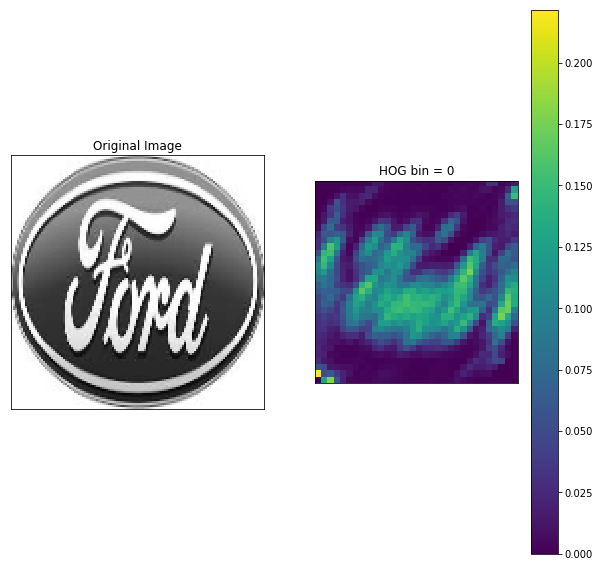

In [4]:
HoG_feature_train = []
for img in range(len(training_imgs)):
    HoG_feature_train.append(compute_HoG_feat(training_imgs[img]))
    

In [5]:
"""Fit a nearest neighbor classifer with three neighbors"""

classify = KNeighborsClassifier(n_neighbors=3)
HoG_train = HoG_train.reshape(10, -1)
clf.fit(HoG_train, y_train)


'Fit a nearest neighbor classifer with three neighbors'

#### Testing

2


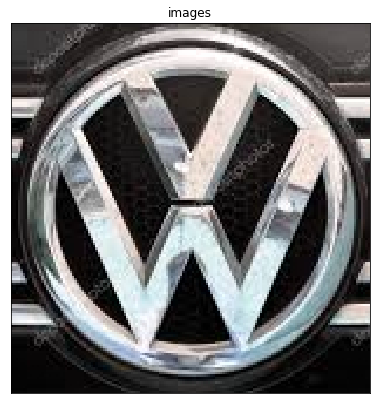

2


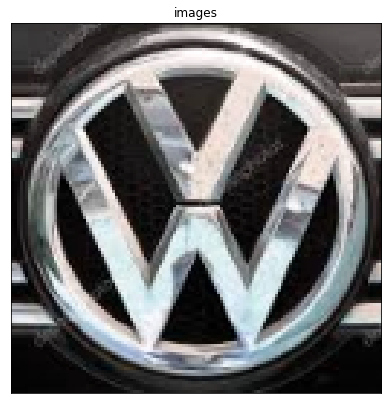

In [9]:
"""Resize test images to 128 x 128"""

test_imgs = []
for name in glob.glob('dataset/*test*'):
    test_imgs.append(cv2.imread(name))
    
print(len(test_imgs))
# display images
plt.figure(figsize=(20,15))
plt.subplot(212), plt.imshow(test_imgs[0])
plt.title("images"), plt.xticks([]), plt.yticks([])
plt.show()
 
for img in range(len(test_imgs)): 
    # explicitly specify dsize=dst.size(); fx and fy will be computed from that.
    test_imgs[img] = cv2.resize(test_imgs[img],(128, 128));
    
print(len(test_imgs))
# display images
plt.figure(figsize=(20,15))
plt.subplot(212), plt.imshow(test_imgs[0])
plt.title("images"), plt.xticks([]), plt.yticks([])
plt.show()


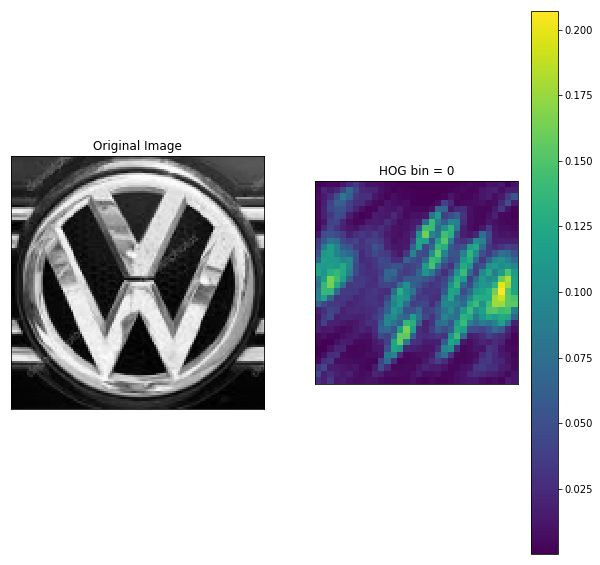

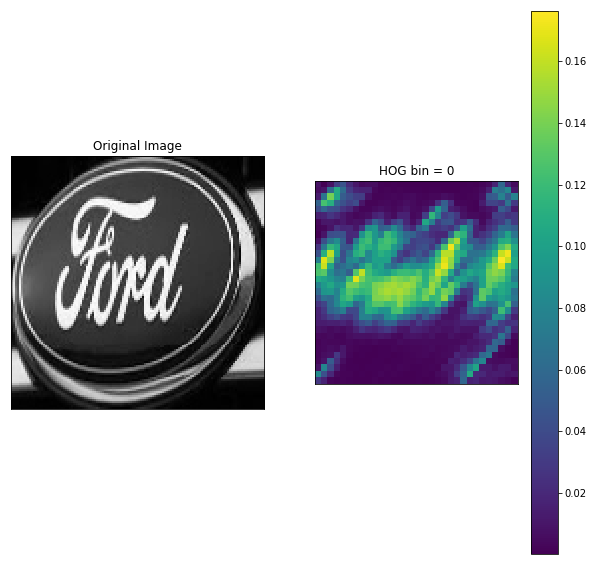

In [10]:
"""Compute HoG features similar to what was done during training and display the features for both test images"""

HoG_feature_test = []
for img in range(len(test_imgs)):
    HoG_feature_test.append(compute_HoG_feat(test_imgs[img]))


### 3.2 Reasoning Questions

##### 1. Will HoG work if images of logos undergo random rotation? If yes, which property of HoG avails this feature? If not, discuss the sequence of computer vision technique(s) that can be used in order to regain uniform orientation of the logos.

It is not. The descriptor is just a histogram of gradient orientations and the orientation bins are chosen w.r.t.
principal image axes. As such, the logos can be rotated by a variation of angles 
and HoG features calculated once again for the rotated images. 

##### 2. Consider that you are given a large dataset with three types of images: variable sized squares with either or both diagonals drawn (see Figure 3). How many and which directions of the gradient are sufficient in order to correctly classify the images into three categories?

Two gradients are sufficient in order classify the images into three categories: the left diagonal alongwith the right diagonal. 
    With those in the dataset, boxes with both diagonals can easily be identified as both orientation datasets would match. 